# Variational Auto-Encoder in Keras

[VAE Recap: Variational Lower Bound](#VAE-Recap:-Variational-Lower-Bound)

[VAE Recap: Structure](#VAE-Recap:-Structure)

[VAE in TensorFlow](#VAE-in-TensorFlow)

[VAR in Keras](#VAE-in-Keras)

- [Load MNIST Data](#Load-MNIST-Data)

- [Build VAE Structure](#Build-VAE-Structure)

- [Define or Restore Models](#Define-or-Restore-Models)

- [Visualization: Latent Space](#Visualization:-Latent-Space)

- [Visualization: 2D manifold of the digits](#Visualization:-2D-manifold-of-the-digits)

- [Visualization: Data Imputation](#Visualization:-Data-Imputation)

[Reparameterization Trick](#Reparameterization-Trick)

## VAE Recap: Variational Lower Bound

### Derive ELBO

<figure>
  <img src="fig/ELBO.png" alt="" width="600">
</figure>

<!-- \begin{align*}
    \log p_{\mathbf{\theta}}(X)
    &=\log\int_{Z} p_{\theta}(X,Z)\\
    &=\log\int_{Z} \frac{{q_{\phi}(Z)}}{{q_{\phi}(Z)}}{p_{\theta}(X,Z)}
     =\log\int_{Z} {q_{\phi}(Z)}\frac{{p_{\theta}(X,Z)}}{{q_{\phi}(Z)}}\\
    &={\log\mathbb{E}_{q_{\phi}(Z)}\frac{p_{\theta}(X,Z)}{q_{\phi}(Z)}} 
    {\geq\mathbb{E}_{q_{\phi}(Z)}\log\frac{p_{\theta}(X,Z)}{q_{\phi}(Z)}}\\
    &\overset{\Delta}{=}\mathcal{L}(\theta,q)
\end{align*} -->

$\mathcal{L}(\theta,q)$ is referred as Variational Lower Bound, {\it a.k.a.} ELBO.

### Calculate GAP

<figure>
  <img src="fig/gap.png" alt="" width="600">
</figure>

<!-- \begin{align*}
  &\log p_{\theta}(X)-\mathcal{L}(\theta,q)\\
  =&\log p_{\theta}(X)
  -\mathbb{E}_{q_{\phi}(Z)}\log\frac{p_{\theta}(X,Z)}{q_{\phi}(Z)}\\
  =&\mathbb{E}_{q_{\phi}(Z)}\left[
  \log p_{\theta}(X)-\log\frac{p_{\theta}(X,Z)}{q_{\phi}(Z)}\right]\\
  =&\mathbb{E}_{q_{\phi}(Z)}\left
  [\log\frac{p_{\theta}(X)}{p_{\theta}(X,Z)}\cdot q_{\phi}(Z)\right]\\
  =&\mathbb{E}_{q_{\phi}(Z)}\left
  [\log\frac{q_{\phi}(Z)}{p_{\theta}(Z\mid X)}\right]\\
  =&{\mathcal{KL}(q_{\phi}(Z)\parallel p_{\theta}(Z\mid X))}
\end{align*} -->

### Understand GAP

<figure>
  <img src="fig/gapfig.png" alt="" width="400">
</figure>

### Calculate ELBO

<figure>
  <img src="fig/revisitELBO.png" alt="" width="600">
</figure> 

#### Our GOAL is to MAXIMIZE $\mathcal{L}(\theta, q)$ (variational lower bound). i.e.  MINIMIZE $-\mathcal{L}(\theta, q)$
Let's calculate each of the two terms.

### Regularization (KL divergence)
*Ref: [the derivation of KL divergence of two Guassians](https://zhuanlan.zhihu.com/p/22464760)*
<figure>
  <img src="fig/klp1p2.svg" alt="" width="550">
</figure>

Common assumptions
- use $\mathcal{N}(0,1)$ as prior for $p(Z)$
- $q(Z\mid X)$ is Gaussian with parameters $(\mu(X),\sigma(X))$ determined by Neural Networks

This can be calculated analytically:
\begin{align*}
-\mathcal{KL}(q_{\phi}(Z\mid X)\parallel p_{\theta}(Z\mid X))
=\frac{1}{2} \sum_{i=1}^N \sum_{s=1}^D
\left(1+\log(\sigma_s^{{(i)}^2})
-\mu_s^{{(i)}^2}
-\sigma_s^{{(i)}^2}\right)
\end{align*}



### Reconstruction (Croos entropy & L2 Loss) 
$$\mathbb{E}_{q_{\phi}(Z\mid X)}\log{p_{\theta}(X \mid Z)}$$
##### Bernoulli $X\sim Ber(Z)$ (cross entropy) 
\begin{equation}  
\left\{  
     \begin{array}{lr}  
     p(X=1\mid Z) = DecoderNeuralNets(Z) = \hat{X}\\
     p(X=0\mid Z) = 1- DecoderNeuralNets(Z)= 1-\hat{X}
     \end{array}  
\right.  
\end{equation}  

$$p(X\mid Z) = \hat{X}^X \cdot (1-\hat{X})^{1-X}$$
$$\log p(X\mid Z) = X \cdot log(\hat{X}) + (1-X) \log(1-\hat{X})=-H(X,\hat{X})$$

$$max \; -H(X,\hat{X}) = min \; H(X,\hat{X})$$
$H$ refers to the [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) in information theory.

##### Continuous $X\sim \mathcal{N}(Z)$ (L2 Loss) 
$$p(X\mid Z)=\frac{1}{\sqrt{2\pi}\sigma} \cdot e^{-\frac{(X-\mu)^2}{2\sigma^2}}$$
$$\log p(X\mid Z) = -\frac{\log(2\pi)\sigma^2}{2} -\frac{(X-\mu)^2}{2\sigma^2}$$
$$\max -\frac{(X-\mu)^2}{2\sigma^2} = \min \; (X-\mu)^2$$

## VAE Recap: Structure

<figure>
  <img src="fig/vaestr1.png" alt="" width="700">
</figure>

More specifically, if you build a VAE based on MLP (multi-layer perceptron), the structure looks like
<figure>
  <img src="fig/vaestr2.png" alt="" width="700">
</figure>

## VAE in TensorFlow

In [5]:
#%% vanillia VAE 

class VAE(object):
    def __init__(self, x, problem, input_dim, hidden_encoder_dim, hidden_decoder_dim, latent_dim, 
                 keep_prob, BN=True, training = None, epsl = 1e-3, lam = 0):

        self.l2_loss = tf.constant(0.0)

        W_encoder_input_hidden = weight_variable([input_dim,hidden_encoder_dim])
        b_encoder_input_hidden = bias_variable([hidden_encoder_dim])
        self.l2_loss += tf.nn.l2_loss(W_encoder_input_hidden)
        
        # Hidden layer encoder
        hidden_encoder = tf.nn.relu(tf.matmul(x, W_encoder_input_hidden) + b_encoder_input_hidden)
        
        W_encoder_hidden_mu = weight_variable([hidden_encoder_dim,latent_dim])
        b_encoder_hidden_mu = bias_variable([latent_dim])
        self.l2_loss += tf.nn.l2_loss(W_encoder_hidden_mu)
        
        # Mu encoder
        mu_encoder = tf.matmul(hidden_encoder, W_encoder_hidden_mu) + b_encoder_hidden_mu
        
        W_encoder_hidden_logvar = weight_variable([hidden_encoder_dim,latent_dim])
        b_encoder_hidden_logvar = bias_variable([latent_dim])
        self.l2_loss += tf.nn.l2_loss(W_encoder_hidden_logvar)
        
        # Sigma encoder
        logvar_encoder = tf.matmul(hidden_encoder, W_encoder_hidden_logvar) + b_encoder_hidden_logvar
        
        # Sample latent variable
        epsilon = tf.random_normal(tf.shape(logvar_encoder), name='epsilon')
        
        std_encoder = tf.exp(0.5 * logvar_encoder)
        self.z = mu_encoder + tf.multiply(std_encoder, epsilon)
        
        W_decoder_z_hidden = weight_variable([latent_dim,hidden_decoder_dim])
        b_decoder_z_hidden = bias_variable([hidden_decoder_dim])
        self.l2_loss += tf.nn.l2_loss(W_decoder_z_hidden)
        
        # Hidden layer decoder
        hidden_decoder = tf.nn.relu(tf.matmul(self.z, W_decoder_z_hidden) + b_decoder_z_hidden)

        W_decoder_hidden_reconstruction = weight_variable([hidden_decoder_dim, input_dim])
        b_decoder_hidden_reconstruction = bias_variable([input_dim])
        self.l2_loss += tf.nn.l2_loss(W_decoder_hidden_reconstruction)
        
        KLD = -0.5 * tf.reduce_sum(1 + logvar_encoder - tf.pow(mu_encoder, 2)\
                                   - tf.exp(logvar_encoder), reduction_indices=1)
        
        self.pred = tf.matmul(hidden_decoder, W_decoder_hidden_reconstruction) \
                    + b_decoder_hidden_reconstruction
        if problem == "classification":
            BCE = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=self.pred, labels=self.x_weighted), reduction_indices=1)
        if problem == "regression":
            BCE = tf.sqrt(tf.nn.l2_loss(self.pred-x)*2)
        
        self.loss = tf.reduce_mean(BCE + KLD)
        
        self.regularized_loss = self.loss + lam * self.l2_loss

## VAE in Keras

### Load MNIST Data

In [1]:
'''
Description: Keras implementation of a variational autoencoder

    1. This VAE is built with MLP (multi-layer perceptron) and tested on MNIST.
    1. You can save trained models.
    2. You can restore trained models to use directly, or train additional epochs.
    3. Visualization includes: latent space, 2D manifold, imputation.
'''
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

from keras.layers import Input, Dense, Lambda
from keras.models import Model, load_model
from keras.regularizers import l2
from keras import backend as K
from keras import objectives
import tensorflow as tf

#%% Load data 
from tensorflow.examples.tutorials.mnist import input_data
#or manually download from: http://yann.lecun.com/exdb/mnist/
mnist = input_data.read_data_sets('MNIST', one_hot=False)
x_train = mnist.train.images
x_test  = mnist.test.images
y_test  = mnist.test.labels

Using TensorFlow backend.


Extracting MNIST\train-images-idx3-ubyte.gz
Extracting MNIST\train-labels-idx1-ubyte.gz
Extracting MNIST\t10k-images-idx3-ubyte.gz
Extracting MNIST\t10k-labels-idx1-ubyte.gz


### Build VAE Structure

In [2]:
# Specify params
np.random.seed(0)  #for reproducibility
            
dim_x       = 784
dim_latent  = 2 
dim_hidden  = 256
batch_size  = 100 
epochs      = 5
decay       = 1e-4 # L2 regularization
epsilon_std = 1.0
use_loss    = 'xent' # 'mse' or 'xent' = - E_q(log(p)) = - \sum_x q(x) * log(p(x))
use_bias    = True

## Encoder
x = Input(batch_shape=(batch_size, dim_x))

h_encoded = Dense(dim_hidden, 
                  kernel_regularizer=l2(decay), bias_regularizer=l2(decay), 
                  use_bias=use_bias, activation='tanh')(x)
z_mean    = Dense(dim_latent, 
                  kernel_regularizer=l2(decay), bias_regularizer=l2(decay), 
                  use_bias=use_bias)(h_encoded)
#why do we encode "log_var" instead of "var"?  <3*> variance is positive
z_log_var = Dense(dim_latent, 
                  kernel_regularizer=l2(decay), bias_regularizer=l2(decay), 
                  use_bias=use_bias)(h_encoded)

## Sampler
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal_variable(shape=(z_mean.get_shape()), mean=0.,
                                       scale=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(dim_latent,))([z_mean, z_log_var])

## Decoder
decoder_hidden = Dense(dim_hidden, 
                       kernel_regularizer=l2(decay), bias_regularizer=l2(decay), 
                       use_bias=use_bias, activation='tanh')
decoder_output = Dense(dim_x, 
                       kernel_regularizer=l2(decay), bias_regularizer=l2(decay), 
                       use_bias=use_bias, activation='sigmoid')
x_hat          = decoder_output(decoder_hidden(z))

## Loss
def loss(x, x_hat):
    loss_kl   = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    loss_xent = dim_x * objectives.binary_crossentropy(x, x_hat)
    loss_mse  = dim_x * objectives.mse(x, x_hat) 
    if use_loss == 'xent':
        return loss_kl + loss_xent
    elif use_loss == 'mse':
        return loss_kl + loss_mse
    else:
        raise Exception('Undefined Loss: %s'%(use_loss))

### Define or Restore Models

Reference of [save and restore in Keras](https://morvanzhou.github.io/tutorials/machine-learning/keras/3-1-save/).

In [3]:
# check if there exists previously trained models
savepath = "./save/"
if not os.path.exists(savepath): os.mkdir(savepath)
if os.path.exists(savepath+"vae.h5"): ## Load trained models
    vae       = load_model(savepath+"vae.h5", custom_objects = {'loss': loss, 'epsilon_std': epsilon_std})
    encoder   = load_model(savepath+"encoder.h5")
    generator = load_model(savepath+"generator.h5", custom_objects = {'epsilon_std': epsilon_std})
    print("\nModels trained for %d epochs successfully restored."%(np.load(savepath+"epochs.npy")))
    
else: ## Train a new model
    vae = Model(x, x_hat)
    vae.compile(optimizer='rmsprop', loss=loss)
    ## train the VAE on MNIST digits
    vae.fit(x_train, x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, x_test))    
    vae.save(savepath+"vae.h5")
    
    ## build a model to project inputs on the latent space
    encoder = Model(x, z_mean)
    encoder.save(savepath+"encoder.h5")
    
    ## build a digit generator that can sample from the learned distribution
    z_sampled = Input(shape=(dim_latent,))
    x_decoded = decoder_output(decoder_hidden(z_sampled))
    generator = Model(z_sampled, x_decoded)
    generator.save(savepath+"generator.h5")
    
    ## document training info
    np.save(savepath+"epochs", epochs)

# you can summarize your model if necessary
vae.summary()

# Please kindly ignore the warning:
#   UserWarning: No training configuration found in save file: 
#   the model was *not* compiled. Compile it manually.

Train on 55000 samples, validate on 10000 samples
Epoch 1/5
55000/55000 [==============================] - 11s - loss: 201.9542 - val_loss: 186.9852
Epoch 2/5
55000/55000 [==============================] - 16s - loss: 182.8704 - val_loss: 179.0592
Epoch 3/5
55000/55000 [==============================] - 17s - loss: 179.3053 - val_loss: 176.5910
Epoch 4/5
55000/55000 [==============================] - 16s - loss: 176.0410 - val_loss: 173.1587
Epoch 5/5
55000/55000 [==============================] - 16s - loss: 172.9785 - val_loss: 171.6866
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (100, 784)            0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (100, 256)        

In [4]:
vae       = load_model(savepath+"vae.h5", custom_objects = {'loss': loss, 'epsilon_std': epsilon_std})

### Visualization: Latent Space

In [9]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
fig = plt.figure(figsize=(4, 4))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()
fig.savefig(savepath+"z_{}.png".format(use_loss))

NameError: name 'encoder' is not defined

### Visualization: 2D manifold of the digits

In [10]:
n = 15  # figure with 15x15 digits
m = 28
figure = np.zeros((m * n, m * n))
# linearly spaced coordinates on the unit square were transformed through 
# the inverse CDF (ppf) of the Gaussian to produce values of the latent 
# variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(m, m)
        figure[i * m: (i + 1) * m,
               j * m: (j + 1) * m] = digit

fig = plt.figure(figsize=(6, 6))
plt.imshow(figure, cmap='Greys_r')
plt.show()
fig.savefig(savepath+"x_{}.png".format(use_loss))

NameError: name 'generator' is not defined

### Visualization: Data Imputation

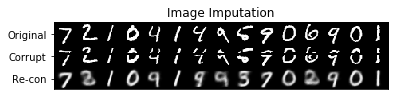

In [27]:
figure = np.zeros((m * 3, m * n))
x_origin = x_test[:batch_size,:]
x_corrupted = np.copy(x_origin)
x_corrupted[:, 300:400] = 0
x_reconstructed = vae.predict(x_corrupted, batch_size=batch_size).reshape((-1, m, m))
x_origin = x_origin.reshape((-1, m, m))
x_corrupted = x_corrupted.reshape((-1, m, m))
for i in range(n):
    figure[:m,      i*m:(i+1)*m] = x_origin[i]
    figure[ m:2*m,  i*m:(i+1)*m] = x_corrupted[i]
    figure[   2*m:, i*m:(i+1)*m] = x_reconstructed[i]

fig = plt.figure(figsize=(6, 3))
plt.imshow(figure, cmap='Greys_r')
plt.title('Image Imputation')
plt.xticks([])
plt.yticks(m*np.array([.5,1.5,2.5]),['Original','Corrupt','Re-con'])
fig.savefig(savepath+"i_{}.png".format(use_loss))

## Reparameterization Trick

<figure>
  <img src="fig/reparam-pic.png" alt="" width="600">
</figure>

*Further readings:*

*[1] [A very simple implementation of  Reparameterisation Tricks](http://nbviewer.jupyter.org/github/gokererdogan/Notebooks/blob/master/Reparameterization%20Trick.ipynb)*

*[2] [Machine Learning Trick of the Day (4): Reparameterisation Tricks](http://blog.shakirm.com/2015/10/machine-learning-trick-of-the-day-4-reparameterisation-tricks/)*

*[3] [Machine Learning Trick of the Day (5): Log Derivative Trick](http://blog.shakirm.com/2015/11/machine-learning-trick-of-the-day-5-log-derivative-trick/)*

*[4] [Machine Learning: A Probabilistic Perspective.](http://dsd.future-lab.cn/members/2015nlp/Machine_Learning.pdf) Ch. 21*
